# NRES pipline comparision
In this Jupyter notebook, we compare the final data products using LCO's stage1, stage2 and CERES. We will also compare a NRES spectrum with the same object from TRES spectrograph. Thanks to D. Latham for providing the TrES spectrum.

## CERES

Currently with CERES, not all order extracted, only orders 10-60. Below is the description of the final data products from CERES. CERES produces fits files with one extension. However, it produces several intermediate products which are saved as separate fits file. The final object fits file can be found in the subdirectory `proc/` of the reduced directory (see details CERES pipeline). 

| Index | Description |
| - | :--- |
| 0 |  Wavelength |
| 1 |  Extracted Flux |
| 2 |  Measurement of the error in the extracted flux ( 1./sqrt(Var) ) |
| 3 |  Blaze corrected Flux |
| 4 |  Measurement of the error in the blaze corrected flux |
| 5 |  Continuum normalized flux |
| 6 |  Measurement of the error in the continuum normalized flux |
| 7 |  Estimated continuum |
| 8 |  Signal-to-noise ratio |
| 9 |  Continumm normalized flux multiplied by the derivative of the wavelength with respect to the pixels |
| 10 | Corresponding error of the 9th entrance |

 

## Stage1 and Stage2:

Stage1 and Stage2 are IDL codes to reduce NRES spectra. All important data products are found in one fits file with different HDU. Below is the description of the HDU of the final fits file.
Filename: lscnrs01-fa09-20190501-0039-e91.fits.fz

| HDU  |  Name  |
| ----------- | ----------- |
|  0 | SPECTRUM   | 
|  1 | SPECRAW    |
|  2 | SPECFLAT   | 
|  3 | SPECBLAZE  | 
|  4 | THARRAW    | 
|  5 | THARFLAT   |  
|  6 | WAVESPEC   | 
|  7 | WAVETHAR   | 
|  8 | SPECXCOR   | 
|  9 | RVBLOCKFIT | 



In [1]:
import os, glob
from astropy.io import fits, ascii
import numpy as np
import pickle
import scipy
import re
from astropy import constants as const
from readmultispec import readmultispec
from PyAstronomy import pyasl
from astropy.modeling import models, fitting
from normalize_spec import get_cont_single
# For bokeh plotting
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import Dark2_5 as palette
# itertools handles the cycling
import itertools  

output_notebook()

# For matplotlib plotting
import matplotlib

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from pylab import rcParams
#rcParams['figure.figsize'] = 20, 20

# create a color iterator
colors = itertools.cycle(palette)    

#define data path for respective data products
dir_ceres = '/home/mrabus/CERES_NRES_reduced/'
archive = '/net/archive/archive/engineering/'
nres_dat = '/home/mrabus/NRES_data/'
stage2_path = '/home/mrabus/struve/targstars/'
tres_path = '/home/mrabus/TRES_spectra/'

plotheight = 450
plotwidth = 450

TOOLTIPS_XY = [
    ("(x,y)", "(@x{0.2f},@y0{0.2f})"),
]


TOOLTIPS_WAVE = [
    ("WAVELENGTH","$x{0.2f}"),
    ("FLUX", "$y{0.2f}")
]


TOOLTIPS_WAVRES = [
    ("WAVELENGTH","$x{0.2f}"),
    ("RESIDUAL", "$y"),
    ("Order", "@order"),
    ("Velocity", "@vel")
]





Loading BokehJS ...

In [2]:
#map the different orders between TrES and NRES so we can compare each order between NRES and TRES
orderkey ={		2  : 9,		6  : 12,	9  : 14,		
				13 : 17,	14 : 18,	16 : 19,	17 : 20,	18 : 21,	20 : 22,	
				21 : 23,	24 : 25,	25 : 26,	27 : 27,	28 : 28,	29 : 29,		
				31 : 30,	32 : 31,	33 : 32,	34 : 33,	39 : 36,	40 : 37,
				41 : 38,	47 : 42,	48 : 43, 	49 : 44, 	50 : 45,
				}

# limits in lambda for each order to compare TRES to NRES
limits ={		2  : [7220,7340	],	6  : [6800,	6922],	9  : [6523,	6620],
				13 : [6165,6274	],	14 : [6082,	6173],	16 : [5949,	6032],	17 : [5851,	5956],	18 : [5780,5860	],	20 : [5652,5738],	
				21 : [5560,	5668],	24 : [5383,	5471],	25 : [5312,	5400],	27 : [5215,	5286],	28 : [5138,	5227],	29 : [5078,	5159],
				31 : [4986,	5055],	32 : [4914,	5003],	33 : [4859,	4938],	34 : [4816,	4870],	39 : [4582,	4651],	40 : [4527,	4605],
				41 : [4488,	4545],	45 : [4346,	4380],	47 : [4238,	4300],	48 : [4197, 4260],	49 : [4160, 4210],	50 : [4124, 4164],
				}

# dictrionary site vs NRES unit
nresunit = {
        'lsc' : 'nres01',
        'elp' : 'nres02',
        'cpt' : 'nres03',
        'tlv' : 'nres04',
}


## Plot raw calibration images

### BIAS

lscnrs01-fa09-20190501-0068-b00.fits.fz
lscnrs01-fa09-20190501-0069-b00.fits.fz
lscnrs01-fa09-20190501-0070-b00.fits.fz
lscnrs01-fa09-20190501-0071-b00.fits.fz
lscnrs01-fa09-20190501-0072-b00.fits.fz
lscnrs01-fa09-20190501-0073-b00.fits.fz
lscnrs01-fa09-20190501-0074-b00.fits.fz
lscnrs01-fa09-20190501-0075-b00.fits.fz
lscnrs01-fa09-20190501-0076-b00.fits.fz
lscnrs01-fa09-20190501-0077-b00.fits.fz


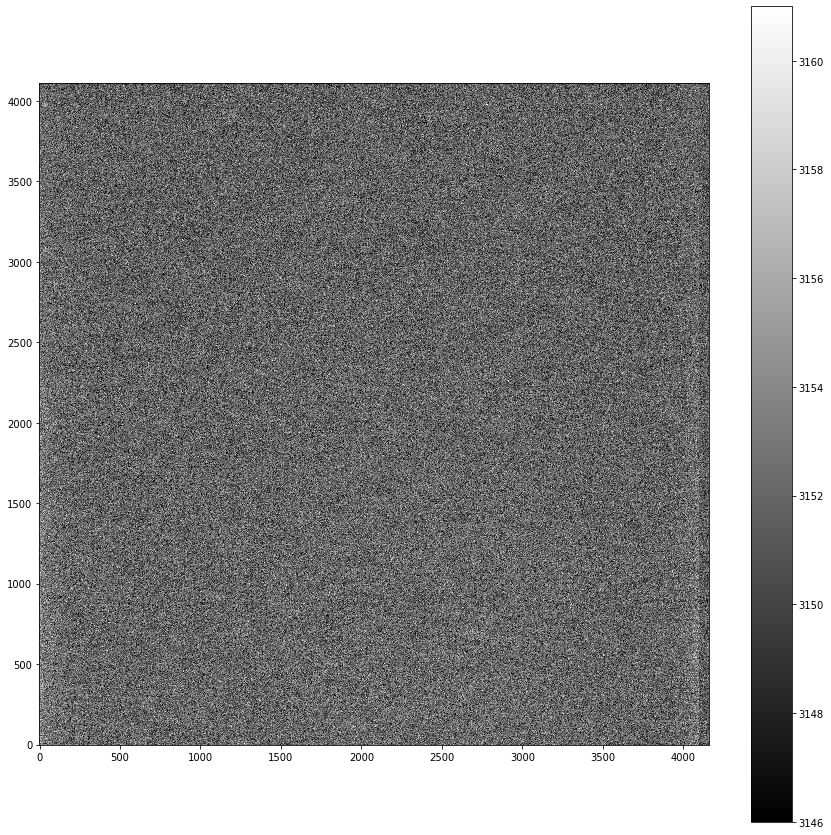

In [3]:
all_bias = glob.glob( os.path.join(archive,'lsc/nres01/20190501/raw/','*-b00.fits.fz') )

for biasf in all_bias:
    print(biasf.split('/')[-1])

image = fits.getdata(all_bias[0])
    
%matplotlib inline
interval = ZScaleInterval()
(vmin,vmax) = interval.get_limits( image )
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax, origin='lower' )
plt.colorbar()


### FLAT

lscnrs01-fa09-20190501-0001-w00.fits.fz
lscnrs01-fa09-20190501-0002-w00.fits.fz
lscnrs01-fa09-20190501-0003-w00.fits.fz
lscnrs01-fa09-20190501-0004-w00.fits.fz
lscnrs01-fa09-20190501-0005-w00.fits.fz
lscnrs01-fa09-20190501-0006-w00.fits.fz
lscnrs01-fa09-20190501-0007-w00.fits.fz
lscnrs01-fa09-20190501-0008-w00.fits.fz
lscnrs01-fa09-20190501-0009-w00.fits.fz
lscnrs01-fa09-20190501-0010-w00.fits.fz
lscnrs01-fa09-20190501-0016-w00.fits.fz
lscnrs01-fa09-20190501-0017-w00.fits.fz
lscnrs01-fa09-20190501-0018-w00.fits.fz
lscnrs01-fa09-20190501-0019-w00.fits.fz
lscnrs01-fa09-20190501-0020-w00.fits.fz
lscnrs01-fa09-20190501-0021-w00.fits.fz
lscnrs01-fa09-20190501-0022-w00.fits.fz
lscnrs01-fa09-20190501-0023-w00.fits.fz
lscnrs01-fa09-20190501-0024-w00.fits.fz
lscnrs01-fa09-20190501-0025-w00.fits.fz


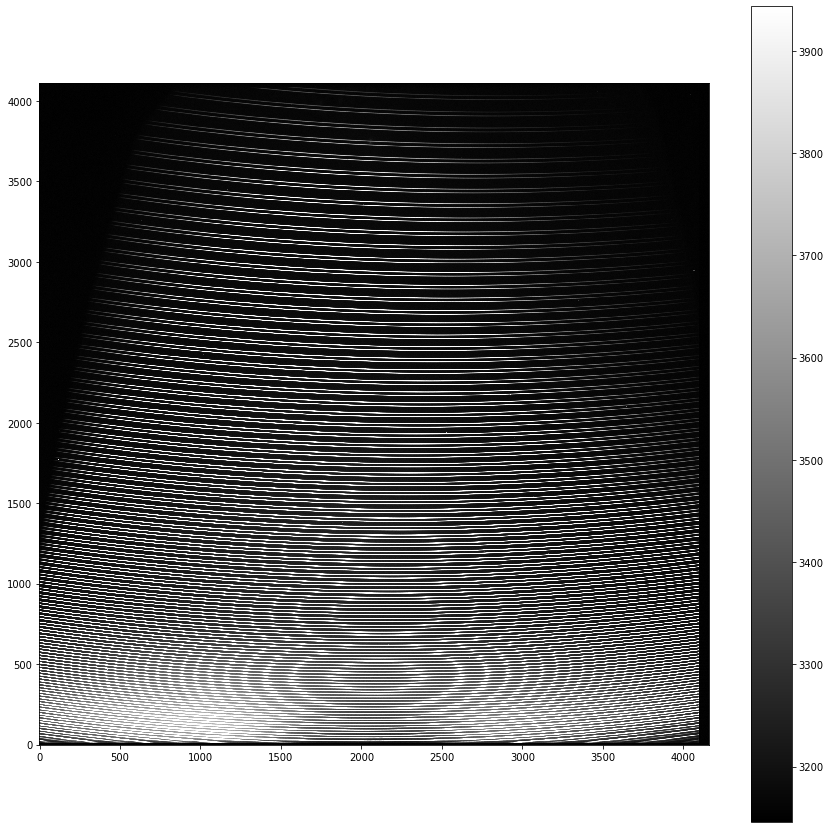

In [4]:
all_flat = glob.glob( os.path.join(archive,'lsc/nres01/20190501/raw/','*-w00.fits.fz') )

for flatf in all_flat:
    print(flatf.split('/')[-1])

image = fits.getdata(all_flat[0])

%matplotlib inline
interval = ZScaleInterval()
(vmin,vmax) = interval.get_limits( image )
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax, origin='lower' )
plt.colorbar()

### ARC

lscnrs01-fa09-20190501-0011-a00.fits.fz
lscnrs01-fa09-20190501-0012-a00.fits.fz
lscnrs01-fa09-20190501-0013-a00.fits.fz
lscnrs01-fa09-20190501-0014-a00.fits.fz
lscnrs01-fa09-20190501-0015-a00.fits.fz
lscnrs01-fa09-20190501-0026-a00.fits.fz
lscnrs01-fa09-20190501-0027-a00.fits.fz
lscnrs01-fa09-20190501-0028-a00.fits.fz
lscnrs01-fa09-20190501-0029-a00.fits.fz
lscnrs01-fa09-20190501-0030-a00.fits.fz


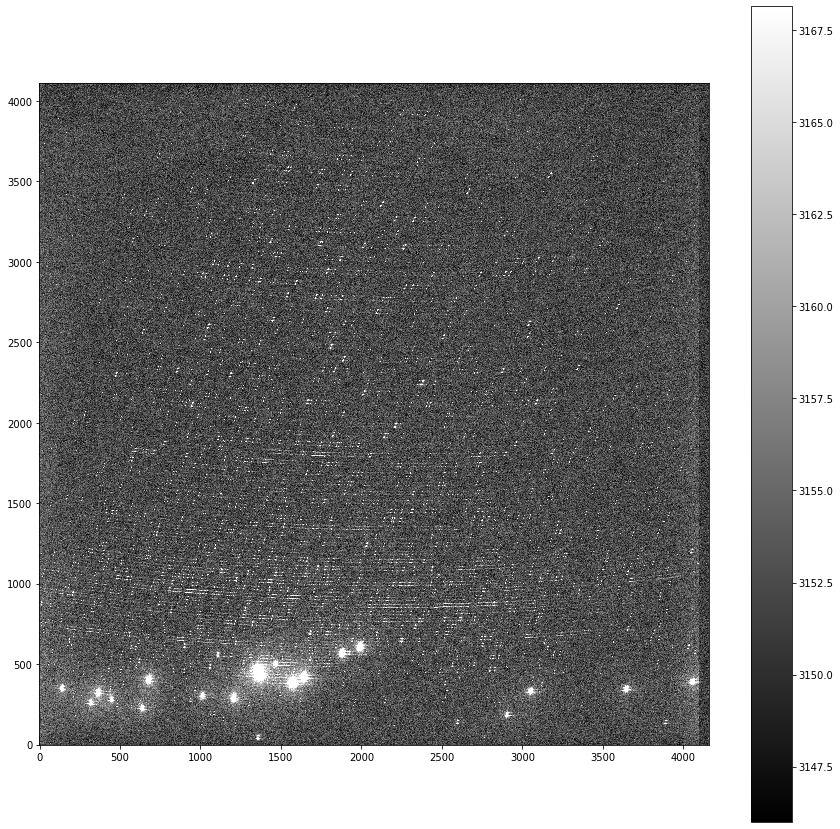

In [5]:
all_arc = glob.glob( os.path.join(archive,'lsc/nres01/20190501/raw/','*-a00.fits.fz') )

for arcf in all_arc:
    print(arcf.split('/')[-1])

image = fits.getdata(all_arc[0])

%matplotlib inline
interval = ZScaleInterval()
(vmin,vmax) = interval.get_limits( image )
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax, origin='lower' )
plt.colorbar()

### Science frame

lscnrs01-fa09-20190501-0033-e00.fits.fz
lscnrs01-fa09-20190501-0032-e00.fits.fz
lscnrs01-fa09-20190501-0034-e00.fits.fz
lscnrs01-fa09-20190501-0035-e00.fits.fz
lscnrs01-fa09-20190501-0036-e00.fits.fz
lscnrs01-fa09-20190501-0037-e00.fits.fz
lscnrs01-fa09-20190501-0042-e00.fits.fz
lscnrs01-fa09-20190501-0041-e00.fits.fz
lscnrs01-fa09-20190501-0043-e00.fits.fz
lscnrs01-fa09-20190501-0044-e00.fits.fz
lscnrs01-fa09-20190501-0045-e00.fits.fz
lscnrs01-fa09-20190501-0046-e00.fits.fz
lscnrs01-fa09-20190501-0047-e00.fits.fz
lscnrs01-fa09-20190501-0048-e00.fits.fz
lscnrs01-fa09-20190501-0049-e00.fits.fz
lscnrs01-fa09-20190501-0050-e00.fits.fz
lscnrs01-fa09-20190501-0051-e00.fits.fz
lscnrs01-fa09-20190501-0052-e00.fits.fz
lscnrs01-fa09-20190501-0053-e00.fits.fz
lscnrs01-fa09-20190501-0054-e00.fits.fz
lscnrs01-fa09-20190501-0055-e00.fits.fz
lscnrs01-fa09-20190501-0056-e00.fits.fz
lscnrs01-fa09-20190501-0057-e00.fits.fz
lscnrs01-fa09-20190501-0058-e00.fits.fz
lscnrs01-fa09-20190501-0059-e00.fits.fz


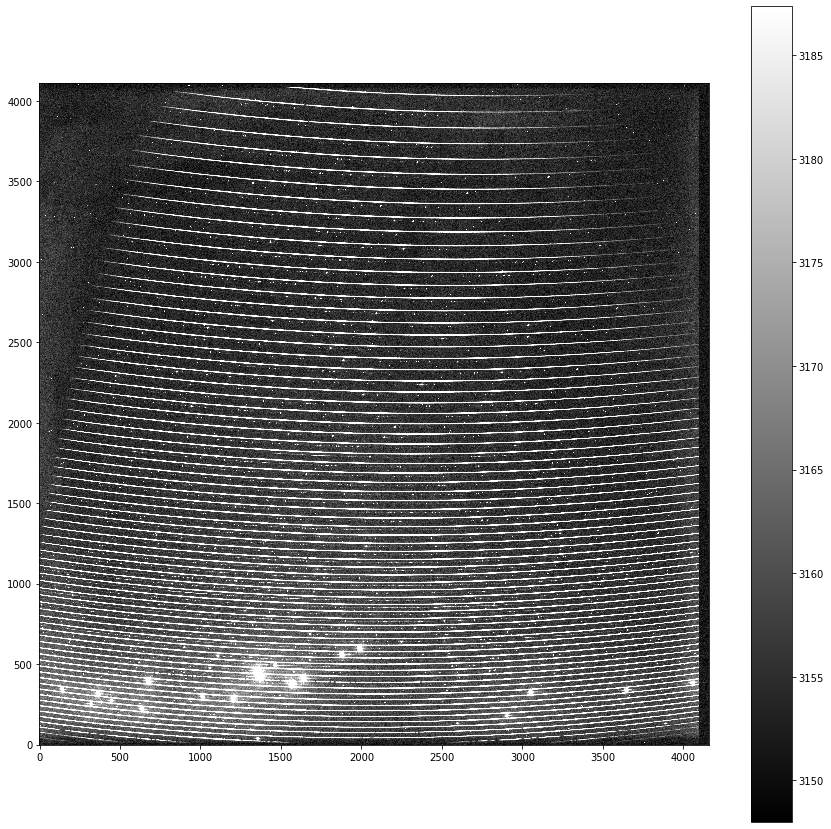

In [6]:
all_science = glob.glob( os.path.join(archive,'lsc/nres01/20190501/raw/','*-e00.fits.fz') )

for sciencef in all_science:
    print(sciencef.split('/')[-1])

image = fits.getdata(all_science[0])

%matplotlib inline
interval = ZScaleInterval()
(vmin,vmax) = interval.get_limits( image )
plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax, origin='lower' )
plt.colorbar()

## Tracing comparision
We compare the tracing between CERES and stage1 pipeline. LCO stage2 uses the same traces as stage1.

For CERES traces are saved in a python `pickle` file.

For stage1 traces are saved in `fits` file.

In [7]:
# Load CERES trace
pickletrace = os.path.join(dir_ceres,'RED_lsc_20190501','trace.pkl')
with open(pickletrace, 'rb') as f:
        trace_dict = pickle.load(f, encoding='bytes')

# Load stage1 trace
trace_fits = fits.open( os.path.join(archive,'lsc/nres01/reduced/','trace/TRAClsc2019120.69836.fits') )


In [8]:
order = 17 #order we want to compare
fiber = 0 # fibre we want to compare
pixel_sampling = 1

#create stage1 trace centers
n_polynomial_coefficients = int(trace_fits[0].header['NPOLY'])
x = np.arange(0, int(trace_fits[0].header['NX']), pixel_sampling)
normalized_x = (0.5 + x) / int(trace_fits[0].header['NX']) - 0.5
normalized_x *= 2.0
coeff_stage1 = trace_fits[0].data[0, fiber, order+10, :n_polynomial_coefficients]
poly_stage1 = np.polynomial.legendre.Legendre(coeff_stage1)
trace_stage1 = poly_stage1(normalized_x)

#create CERES trace centers
trace_cc = trace_dict[b'c_ob'][order]
trace_ceres = scipy.polyval( trace_cc,x )

### Compare the traces
First we plot central position as function of pixel along the dispersion direction.
Second we plot the difference at each pixel along the dispersion between CERES and stage1.

In [9]:
source1 = ColumnDataSource( data=dict(
        x = x,
        y0 = trace_ceres,
        y1 = trace_stage1,
        res = trace_ceres-trace_stage1 ))


bfig_trace1 = figure( width=plotwidth*2, plot_height=plotheight)
bfig_trace1.line( 'x','y0',line_color="blue",line_width=3, source=source1, legend='CERES' )
bfig_trace1.line( 'x','y1',line_color="red",line_width=3, source=source1,legend='STAGE1' )
bfig_trace1.xaxis.axis_label = 'Pixels'
bfig_trace1.yaxis.axis_label = 'Pixels'
bfig_trace2 = figure( width=plotwidth*2, plot_height=plotheight, x_range=bfig_trace1.x_range)

bfig_trace2.line( 'x','res',line_color="blue",line_width=3, source=source1, )
bfig_trace2.xaxis.axis_label = 'Pixels'
bfig_trace2.yaxis.axis_label = 'Residuals'
p = gridplot([[bfig_trace1], [bfig_trace2]])
show(p)



Next we plot a flat image and overplot the different traces in blue (CERES central position) and red (stage1 central position).

In [10]:
# Load flat image.
image = fits.getdata(os.path.join(archive,'lsc/nres01/20190501/','raw/lscnrs01-fa09-20190501-0006-w00.fits.fz'),
                     extname='SPECTRUM')

(3600, 3800)

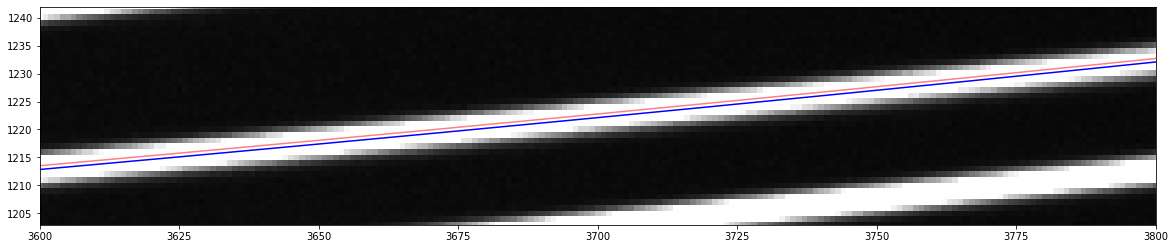

In [11]:
xlimits=[3600,3800]

%matplotlib inline
interval = ZScaleInterval()
(vmin,vmax) = interval.get_limits( image )
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gist_gray', vmin=vmin, vmax=vmax, origin='lower' )
plt.plot(x,trace_ceres,'b',alpha=1)
plt.plot(x,trace_stage1,'r',alpha=0.5)
mask = (x < xlimits[1]) & (x > xlimits[0])

plt.ylim(np.min(trace_ceres[mask])-10,np.max(trace_ceres[mask])+10)
plt.xlim(xlimits[0],xlimits[1])

## Wavelength solution comparision

### CERES:
Creates an initial wavelength solution based on arc frames. Shifts the science frame wavelength solution. Wavelength solution is saved in a `pickle` file.

### Stage1:
Creates a averaged wavelength solution. Wavelength solution is saved in a `fits` file.

## Comparing residuals for LSC

In [12]:
#Load CERES wavelength solution
pickleobj = os.path.join(dir_ceres,'RED_lsc_20190501','lscnrs01-fa09-20190501-0015-a00.wavsolpars.pkl')
with open(pickleobj, 'rb') as f:
        pdict = pickle.load(f, encoding='bytes')

#Load stage1 wavelength solution
hdu_thar = fits.open( os.path.join(archive,'lsc/nres01/reduced/','thar/THARlsc2019122.07153.fits') )



We are interested to compare the wavelength residuals as function of wavlength. CERES treats wavelength in Angstrom, stage1 uses micron.

In [13]:
source_stage1 = ColumnDataSource( data=dict(
    x=hdu_thar[3].data['matchlam']*10, #multiply by 10 to obtain Angstrom
    y=hdu_thar[3].data['matchdif']*10,
    order=hdu_thar[3].data['matchord'],
    vel = const.c * hdu_thar[3].data['matchdif'] / hdu_thar[3].data['matchlam']# convert wavelength difference to m/s
    ))

ords_ob = pdict[b'G_ord']
wavs_ob = pdict[b'G_wav']
ress_ob = pdict[b'G_res']
cent_ob = pdict[b'G_pix']

ords_co = pdict[b'G_ord_co']
wavs_co = pdict[b'G_wav_co']
ress_co = pdict[b'G_res_co']
cent_co = pdict[b'G_pix_co']

ods_ob = np.unique(ords_ob)
ods_co = np.unique(ords_co)

source_ob = ColumnDataSource( data=dict(
    x=wavs_ob,
    y=ress_ob,
    order=ords_ob,
    vel = const.c * ress_ob / wavs_ob
    ))

source_co = ColumnDataSource( data=dict(
    x=wavs_co,
    y=ress_co,
    order=ords_co,
    vel = const.c * ress_co / wavs_co
    ))



In [14]:
bfig_wavob = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVRES)#,tools=select_tools)
bfig_wavob.circle('x','y',size=5, source=source_ob, color ='red', legend='CERES' )
bfig_wavob.circle('x','y',size=5, source=source_stage1, color = 'blue', legend='STAGE1' )
bfig_wavob.xaxis.axis_label = 'Wavelength [Angstrom]'
bfig_wavob.yaxis.axis_label = 'Residuals [Angstrom]'
#bfig_wavco = figure( width=plotwidth, plot_height=plotheight, tooltips=TOOLTIPS_res)#,tools=select_tools)
#bfig_wavco.circle('x','y',size=5, source=source_co)
    
#p = gridplot([[bfig_wavob, bfig_wavco]])
#show(p)

show(bfig_wavob)

## Comparing residuals for CPT

In [15]:
pickleobj = os.path.join(dir_ceres,'RED_cpt_20190501','cptnrs03-fa13-20190501-0015-a00.wavsolpars.pkl')
with open(pickleobj, 'rb') as f:
        pdict = pickle.load(f, encoding='bytes')
        
hdu_thar = fits.open( os.path.join(archive,'cpt/nres03/reduced/','thar/THARcpt2019122.01925.fits') )


In [16]:
source_stage1 = ColumnDataSource( data=dict(
    x=hdu_thar[3].data['matchlam']*10,
    y=hdu_thar[3].data['matchdif']*10,
    order=hdu_thar[3].data['matchord'],
    vel = const.c * hdu_thar[3].data['matchdif'] / hdu_thar[3].data['matchlam']
    ))

ords_ob = pdict[b'G_ord']
wavs_ob = pdict[b'G_wav']
ress_ob = pdict[b'G_res']
cent_ob = pdict[b'G_pix']

ords_co = pdict[b'G_ord_co']
wavs_co = pdict[b'G_wav_co']
ress_co = pdict[b'G_res_co']
cent_co = pdict[b'G_pix_co']

ods_ob = np.unique(ords_ob)
ods_co = np.unique(ords_co)

source_ob = ColumnDataSource( data=dict(
    x=wavs_ob,
    y=ress_ob,
    order=ords_ob,
    vel = const.c * ress_ob / wavs_ob
    ))

source_co = ColumnDataSource( data=dict(
    x=wavs_co,
    y=ress_co,
    order=ords_co,
    vel = const.c * ress_co / wavs_co
    ))



In [17]:
bfig_wavob = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVRES)#,tools=select_tools)
bfig_wavob.circle('x','y',size=5, source=source_ob, color ='red', legend='CERES' )
bfig_wavob.circle('x','y',size=5, source=source_stage1, color = 'blue', legend='STAGE1' )
bfig_wavob.xaxis.axis_label = 'Wavelength [Angstrom]'
bfig_wavob.yaxis.axis_label = 'Residuals [Angstrom]'
#bfig_wavco = figure( width=plotwidth, plot_height=plotheight, tooltips=TOOLTIPS_res)#,tools=select_tools)
#bfig_wavco.circle('x','y',size=5, source=source_co)
    
#p = gridplot([[bfig_wavob, bfig_wavco]])
#show(p)

show(bfig_wavob)

## A closer look at arc files
We compare the arcfiles and wavelength solution for LCO's stage1, stage2 and CERES.

In [18]:
spec_ceres_co = fits.getdata( os.path.join(dir_ceres,'RED_lsc_20190501/','lscnrs01-fa09-20190501-0039-e00._sp_co.fits') )
hdu_stag1 = fits.open( os.path.join(nres_dat,'20190501_lsc/specproc/lscnrs01-fa09-20190501-0039-e91/lscnrs01-fa09-20190501-0039-e91.fits.fz') )
hdu_stag2 = fits.open( os.path.join(stage2_path,'HD126053/red2/lscnrs01-fa09-20190501-0039-e91.avg.fits') )

### How does the arc extraction compare between the different pipelines?



In [19]:
source1co = ColumnDataSource( data=dict(
    x=spec_ceres_co[0,order,:],
    y=spec_ceres_co[1,order,:]  #  3 blaze corrected, 5 continuum normalized
    ))

source2co = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVETHAR'].data[order+10,:]*10,
    y=hdu_stag1['THARFLAT'].data[order+10,:] 
    ))

source3co = ColumnDataSource( data=dict(
    x=hdu_stag2['WAVETHAR'].data[order+10,:]*10,
    y=hdu_stag2['THARFLAT'].data[order+10,:] 
    ))

bfig_arc1 = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig_arc1.line( 'x','y',line_color="blue",line_width=3,source=source1co, legend='CERES' )
bfig_arc1.line( 'x','y',line_color="red",line_width=3,source=source2co, legend='STAGE1' )
bfig_arc1.line( 'x','y',line_color="green",line_width=3,source=source3co, legend='STAGE2 avg.' )
bfig_arc1.xaxis.axis_label = 'Wavelength [Angstrom]'
bfig_arc1.yaxis.axis_label = 'Flux'
show(bfig_arc1)

### How does the wavelength solution compare between orders? 

NRES has strong overlap in wavelength between the orders, beginning and end of each order should overlap with the previous and succeeding order. We plot stage1 spectra for orders 49,50 and 51.

In [20]:
order=50 #define central order, we plot 50-1,50,50+1
sourcest1a = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVETHAR'].data[order+9,:]*10,
    y=hdu_stag1['THARFLAT'].data[order+9,:] 
    ))

sourcest1b = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVETHAR'].data[order+10,:]*10,
    y=hdu_stag1['THARFLAT'].data[order+10,:] 
    ))

sourcest1c = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVETHAR'].data[order+11,:]*10,
    y=hdu_stag1['THARFLAT'].data[order+11,:] 
    ))

bfig_arc2 = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig_arc2.line( 'x','y',line_color="blue",line_width=3,source=sourcest1a, legend='Order: '+str(order+9) )
bfig_arc2.line( 'x','y',line_color="red",line_width=3,source=sourcest1b, legend='Order: '+str(order+10) )
bfig_arc2.line( 'x','y',line_color="green",line_width=3,source=sourcest1c, legend='Order: '+str(order+11) )
bfig_arc2.xaxis.axis_label = 'Wavelength [Angstrom]'
bfig_arc2.yaxis.axis_label = 'Flux'
show(bfig_arc2)

### How does the arc spectra compare between sites?
NRES has 4 different site and here we compare the extracted stage1 data between different sites

In [22]:
site1 = 'cpt'
rootdir1 	= os.path.join( '/net/archive/archive/engineering/',site1,nresunit[site1] )
spec_hdu1 	= fits.open( '/home/mrabus/NRES_checks/'+site1+'/20190501/specproc/cptnrs03-fa13-20190501-0028-e91/cptnrs03-fa13-20190501-0028-e91.fits.fz' )
datstrng    = spec_hdu1[0].header['DATSTRNG']
thar_hdu1 	= fits.open( os.path.join( rootdir1,'reduced/thar','THAR'+datstrng+'.fits' ) )

site2 = 'elp'
rootdir2 	= os.path.join( '/net/archive/archive/engineering/',site2,nresunit[site2] )
spec_hdu2 	= fits.open( '/home/mrabus/NRES_checks/'+site2+'/20190501/specproc/elpnrs02-fa17-20190501-0012-e91/elpnrs02-fa17-20190501-0012-e91.fits.fz' )
datstrng    = spec_hdu2[0].header['DATSTRNG']
thar_hdu2 	= fits.open( os.path.join( rootdir2,'reduced/thar','THAR'+datstrng+'.fits' ) )

site3 = 'lsc'
rootdir3 	= os.path.join( '/net/archive/archive/engineering/',site3,nresunit[site3] )
spec_hdu3 	= fits.open( '/home/mrabus/NRES_checks/'+site3+'/20190501/specproc/lscnrs01-fa09-20190501-0039-e91/lscnrs01-fa09-20190501-0039-e91.fits.fz' )
datstrng    = spec_hdu3[0].header['DATSTRNG']
thar_hdu3 	= fits.open( os.path.join( rootdir3,'reduced/thar','THAR'+datstrng+'.fits' ) )

site4 = 'tlv'
rootdir4 	= os.path.join( '/net/archive/archive/engineering/',site4,nresunit[site4] )
spec_hdu4 	= fits.open( '/home/mrabus/NRES_checks/'+site4+'/20190501/specproc/tlvnrs04-fa18-20190501-0016-e91/tlvnrs04-fa18-20190501-0016-e91.fits.fz' )
datstrng    = spec_hdu4[0].header['DATSTRNG']
thar_hdu4 	= fits.open( os.path.join( rootdir4,'reduced/thar','THAR'+datstrng+'.fits' ) )

lam1 = thar_hdu1[3].data['matchlam']
lam2 = thar_hdu2[3].data['matchlam']
lam3 = thar_hdu3[3].data['matchlam']
lam4 = thar_hdu4[3].data['matchlam']

order = 28 

lam_thar1 	= spec_hdu1[7].data[order,:]
thar_spec1 	= spec_hdu1[5].data[order,:]

lam_thar2 	= spec_hdu2[7].data[order,:]
thar_spec2 	= spec_hdu2[5].data[order,:]

lam_thar3 	= spec_hdu3[7].data[order,:]
thar_spec3 	= spec_hdu3[5].data[order,:]

lam_thar4 	= spec_hdu4[7].data[order,:]
thar_spec4 	= spec_hdu4[5].data[order,:]

source1 = ColumnDataSource( data=dict(
        x = np.arange(spec_hdu1[7].data[order,:].shape[0]),
        x1 = spec_hdu1[7].data[order,:],
        y1 = spec_hdu1[5].data[order,:],
        x2 = spec_hdu2[7].data[order,:],
        y2 = spec_hdu2[5].data[order,:],
        x3 = spec_hdu3[7].data[order,:],
        y3 = spec_hdu3[5].data[order,:],
        x4 = spec_hdu4[7].data[order,:],
        y4 = spec_hdu4[5].data[order,:],))


bfig_site1 = figure( width=plotwidth*2, plot_height=plotheight)
bfig_site1.line( 'x','y1',line_color="blue",line_width=3, source=source1, legend=site1 )
bfig_site1.line( 'x','y2',line_color="red",line_width=3, source=source1,legend=site2 )
bfig_site1.line( 'x','y3',line_color="green",line_width=3, source=source1, legend=site3 )
bfig_site1.line( 'x','y4',line_color="cyan",line_width=3, source=source1,legend=site4 )
bfig_site1.xaxis.axis_label = 'Pixels'
bfig_site1.yaxis.axis_label = 'Flux'

bfig_site2 = figure( width=plotwidth*2, plot_height=plotheight, )
bfig_site2.line( 'x1','y1',line_color="blue",line_width=3, source=source1, legend=site1 )
bfig_site2.line( 'x2','y2',line_color="red",line_width=3, source=source1,legend=site2 )
bfig_site2.line( 'x3','y3',line_color="green",line_width=3, source=source1, legend=site3 )
bfig_site2.line( 'x4','y4',line_color="cyan",line_width=3, source=source1,legend=site4 )
bfig_site2.xaxis.axis_label = 'Angstrom'
bfig_site2.yaxis.axis_label = 'Flux'
p = gridplot([[bfig_site1], [bfig_site2]])
show(p)

## Between fibres
At each site NRES spectrographs can be fed by two telescopes. However, only one at a time is choosen to avoid overlap of the order in the red. Only TLV has one telescope. We can compare the arc spectra between the two telescope used. We plot stage1 data.

In [45]:
hdu_dble = fits.open( os.path.join(archive,'lsc/nres01/reduced/','dble/DBLElsc2019122.71069.fits') )

In [47]:
order=20

spec0 		= hdu_dble['SPECTRUM'].data[0,order,:]
spec1 		= hdu_dble['SPECTRUM'].data[1,order,:]

x = np.arange(spec0.shape[0])

sourcef0 = ColumnDataSource( data=dict(
    x=x,
    y=spec0
    ))

sourcef1 = ColumnDataSource( data=dict(
    x=x,
    y=spec1
    ))


bfig_dble = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig_dble.line( 'x','y',line_color="blue",line_width=3,source=sourcef0, legend='Fibre 0' )
bfig_dble.line( 'x','y',line_color="red",line_width=3,source=sourcef1, legend='Fibre 1' )
bfig_dble.xaxis.axis_label = 'Pixel'
bfig_dble.yaxis.axis_label = 'Flux'
show(bfig_dble)

## A closer look at the science spectra

We plot stage1 science spectra for three consecutive order:



In [23]:
order=49
sourcest1a = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVESPEC'].data[order+9,:]*10,
    y=hdu_stag1['SPECFLAT'].data[order+9,:] 
    ))

sourcest1b = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVESPEC'].data[order+10,:]*10,
    y=hdu_stag1['SPECFLAT'].data[order+10,:] 
    ))

sourcest1c = ColumnDataSource( data=dict(
    x=hdu_stag1['WAVESPEC'].data[order+11,:]*10,
    y=hdu_stag1['SPECFLAT'].data[order+11,:] 
    ))

bfig_order = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, title='Stage 1')#,tools=select_tools)
bfig_order.line( 'x','y',line_color="blue",line_width=3,source=sourcest1a, legend='Order: '+str(order+9) )
bfig_order.line( 'x','y',line_color="red",line_width=3,source=sourcest1b, legend='Order: '+str(order+10) )
bfig_order.line( 'x','y',line_color="green",line_width=3,source=sourcest1c, legend='Order: '+str(order+11) )
bfig_order.xaxis.axis_label = 'Angstrom'
bfig_order.yaxis.axis_label = 'Flux'
show(bfig_order)

### Science spectra between different pipelines and spectrographs in the case of HD126053

HD126053 is a RV standard star spectral type G, showing a stable RVs.

TRES (Tillinghast Reflector Echelle Spectrograph) is a fiber-fed (sky+object+calibration spectrum) optical echelle spectrograph on the 1.5-meter Tillinghast telescope at the Smithsonian Astrophysical Observatory's Fred L. Whipple Observatory on Mt. Hopkins in Arizona. 

The design is a high-throughput fiber-fed echelle. It is cross-dispersed, yielding a passband of 390-910 nm. It accommodates 3 optical fiber pairs (science+sky) and offers 3 resolutions, 60K, 48K and 30K. 

In [24]:
spec_ceres,ceres_header = fits.getdata( os.path.join(dir_ceres,'RED_lsc_20190501/proc','HD126053_20190502_UT01:43:16.930_sp.fits') , header = True)
hdu_stag1 = fits.open( os.path.join(nres_dat,'20190501_lsc/specproc/lscnrs01-fa09-20190501-0039-e91/lscnrs01-fa09-20190501-0039-e91.fits.fz') )
hdu_stag2 = fits.open( os.path.join(stage2_path,'HD126053/red2/lscnrs01-fa09-20190501-0039-e91.avg.fits') )
tres_dat = readmultispec( os.path.join(tres_path,'HD126053_2019-05-03_06h01m38s_cb.spec.fits') )

Dispersion is order-5 Legendre polynomial (NEEDS TEST)
Correcting for redshift: z=0.000000


In [39]:
lbary_ltopo = ceres_header['HIERARCH (LAMBDA_BARY / LAMBDA_TOPO)'] #Load barycentri correction from CERES pipeline

ww_tres = np.zeros(tres_dat['wavelen'].shape)
ff_tres = np.zeros(tres_dat['flux'].shape)
for iord in range(ww_tres.shape[0]):
	ww_tres[iord,:] = pyasl.airtovac2(tres_dat['wavelen'][-(iord+1),:]) #convert TRES wavelength to vacuum
	ff_tres[iord,:] = tres_dat['flux'][-(iord+1),:]

ww_stag1 = hdu_stag1['WAVESPEC'].data*10
ff_stag1 = hdu_stag1['SPECBLAZE'].data+10000

ww_stag2 = hdu_stag2['WAVESPEC'].data*10
ff_stag2 = hdu_stag2['SPECBLAZE'].data+10000


In [40]:
order = 17 #20#17
wave_ceres = spec_ceres[0,order,:]/lbary_ltopo
flux_ceres = spec_ceres[3,order,:]
idx = (wave_ceres < limits[order][1]) & (wave_ceres > limits[order][0])
wave_ceres = wave_ceres[idx]
flux_ceres = flux_ceres[idx]
ccoefs_ceres = get_cont_single(wave_ceres,flux_ceres)
flux_ceres = flux_ceres/np.polyval(ccoefs_ceres, wave_ceres)


wave_stag1 = ww_stag1[order+10,:]
flux_stag1 = ff_stag1[order+10,:]#/np.polyval(ccoefs_stag1[order],wave_stag1)
idx = (wave_stag1 < limits[order][1]) & (wave_stag1 > limits[order][0])
wave_stag1 = wave_stag1[idx]
flux_stag1 = flux_stag1[idx]
ccoefs_stag1 = get_cont_single(wave_stag1,flux_stag1)
flux_stag1 = flux_stag1/np.polyval(ccoefs_stag1, wave_stag1)


wave_stag2 = ww_stag2[order+10,:]
flux_stag2 = ff_stag2[order+10,:]#/np.polyval(ccoefs_stag2[order],wave_stag2)
idx = (wave_stag2 < limits[order][1]) & (wave_stag2 > limits[order][0])
wave_stag2 = wave_stag2[idx]
flux_stag2 = flux_stag2[idx]
ccoefs_stag2 = get_cont_single(wave_stag2,flux_stag2)
flux_stag2 = flux_stag2/np.polyval(ccoefs_stag2, wave_stag2)

wave_tres = ww_tres[orderkey[order],:]
flux_tres = ff_tres[orderkey[order],:]#/np.polyval(ccoefs_tres[orderkey[order]],wave_tres)
idx = (wave_tres < limits[order][1]) & (wave_tres > limits[order][0])
wave_tres = wave_tres[idx]
flux_tres = flux_tres[idx]
ccoefs_tres = get_cont_single(wave_tres,flux_tres)
flux_tres = flux_tres/np.polyval(ccoefs_tres,wave_tres)



In [41]:
source1 = ColumnDataSource( data=dict(
    x=wave_ceres,
    y=flux_ceres
    ))

source2 = ColumnDataSource( data=dict(
    x=wave_stag1,
    y=flux_stag1
    ))

source3 = ColumnDataSource( data=dict(
    x=wave_stag2,
    y=flux_stag2 
    ))

source4 = ColumnDataSource( data=dict(
    x=wave_tres,
    y=flux_tres
    ))


bfig = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig.line( 'x','y',line_color="blue",line_width=3,source=source1, legend='CERES' )
bfig.line( 'x','y',line_color="red",line_width=3,source=source2, legend='STAGE1' )
bfig.line( 'x','y',line_color="green",line_width=3,source=source3, legend='STAGE2 avg.' )
bfig.line( 'x','y',line_color="cyan",line_width=3,source=source4, legend='TrES' )
bfig.xaxis.axis_label = 'Angstrom'
bfig.yaxis.axis_label = 'relative flux'
show(bfig)

### Comparing a specific line

Sodium D-line at ~5890 Angstrom. We fit a vogt profile to this line for each pipeline as well as the TrES spectra. Fitted central position is shown in legend.

In [29]:
fit_voigt = fitting.LevMarLSQFitter()

line_profile = models.Voigt1D(x_0=5891, amplitude_L=-0.2, fwhm_L=0.5 )

idxc = (wave_ceres < 5893) & (wave_ceres > 5889.5)
ceresfluxf = flux_ceres[idxc]-1
cereswavef = wave_ceres[idxc]
ab_line_ceres = fit_voigt(line_profile, cereswavef, ceresfluxf)

idx1 = (wave_stag1 < 5893) & (wave_stag1 > 5889.5)
st1fluxf = flux_stag1[idx1]-1
st1wavef = wave_stag1[idx1]
ab_line_st1 = fit_voigt(line_profile, st1wavef, st1fluxf)

idx2 = (wave_stag2 < 5893) & (wave_stag2 > 5889.5)
st2fluxf = flux_stag2[idx2]-1
st2wavef = wave_stag2[idx2]
ab_line_st2 = fit_voigt(line_profile, st2wavef, st2fluxf)

idxt = (wave_tres < 5893) & (wave_tres > 5889.5)
tresfluxf = flux_tres[idxt]-1
treswavef = wave_tres[idxt]
ab_line_tres = fit_voigt(line_profile, treswavef, tresfluxf)

bfig = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig.line( cereswavef,ceresfluxf,line_color="blue",line_width=3, legend='CERES:   {:.4f}'.format(ab_line_ceres.parameters[0]) )
bfig.line( st1wavef,st1fluxf,line_color="red",line_width=3, legend='STAGE1:   {:.4f}'.format(ab_line_st1.parameters[0]) )
bfig.line( st2wavef,st2fluxf,line_color="green",line_width=3, legend='STAGE2:   {:.4f}'.format(ab_line_st2.parameters[0]) )
bfig.line( treswavef,tresfluxf,line_color="cyan",line_width=3, legend='TRES:   {:.4f}'.format(ab_line_tres.parameters[0]) )
bfig.xaxis.axis_label = 'Angstrom'
bfig.yaxis.axis_label = 'relative flux'
show(bfig)

## Spectra between sites
We compare stage1 and CERES spectra between differnt sites. The same object was observed on different sites.

In [30]:
spec_ceresb,ceres_headerb = fits.getdata( os.path.join(dir_ceres,'RED_cpt_20190501/proc','HD126053_20190501_UT20:03:04.400_sp.fits') , header = True)
hdu_stag1b = fits.open( os.path.join(nres_dat,'20190501_cpt/specproc/cptnrs03-fa13-20190501-0028-e91/cptnrs03-fa13-20190501-0028-e91.fits.fz') )

In [33]:
lbary_ltopob = ceres_headerb['HIERARCH (LAMBDA_BARY / LAMBDA_TOPO)']

ww_stag1b = hdu_stag1b['WAVESPEC'].data*10
ff_stag1b = hdu_stag1b['SPECBLAZE'].data+10000


In [34]:
order = 17 #20#17
wave_ceresb = spec_ceresb[0,order,:]/lbary_ltopob
flux_ceresb = spec_ceresb[3,order,:]
idx = (wave_ceresb < limits[order][1]) & (wave_ceresb > limits[order][0])
wave_ceresb = wave_ceresb[idx]
flux_ceresb = flux_ceresb[idx]
ccoefs_ceres = get_cont_single(wave_ceresb,flux_ceresb)
flux_ceresb = flux_ceresb/np.polyval(ccoefs_ceres, wave_ceresb)


wave_stag1b = ww_stag1b[order+10,:]
flux_stag1b = ff_stag1b[order+10,:]#/np.polyval(ccoefs_stag1[order],wave_stag1)
idx = (wave_stag1b < limits[order][1]) & (wave_stag1b > limits[order][0])
wave_stag1b = wave_stag1b[idx]
flux_stag1b = flux_stag1b[idx]
ccoefs_stag1 = get_cont_single(wave_stag1b,flux_stag1b)
flux_stag1b = flux_stag1b/np.polyval(ccoefs_stag1, wave_stag1b)



In [35]:
source1bb = ColumnDataSource( data=dict(
    x=wave_ceresb,
    y=flux_ceresb
    ))

source2bb = ColumnDataSource( data=dict(
    x=wave_stag1b,
    y=flux_stag1b
    ))



bfig = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig.line( 'x','y',line_color="blue",line_width=3,source=source1, legend='LSC CERES' )
bfig.line( 'x','y',line_color="red",line_width=3,source=source2, legend='LSC STAGE1' )
bfig.line( 'x','y',line_color="green",line_width=3,source=source1bb, legend='CPT CERES' )
bfig.line( 'x','y',line_color="cyan",line_width=3,source=source2bb, legend='CPT STAGE1' )
bfig.xaxis.axis_label = 'Angstrom'
bfig.yaxis.axis_label = 'relative flux'
show(bfig)

### Comparing a specific line

Sodium D-line at ~5890 Angstrom. We fit a vogt profile to this line for stage1 and CERES and also compare between different sites. Fitted central position is shown in legend.

In [43]:
fit_voigt = fitting.LevMarLSQFitter()

line_profile = models.Voigt1D(x_0=5891, amplitude_L=-0.2, fwhm_L=0.5 )

idxc = (wave_ceres < 5893) & (wave_ceres > 5889.5)
ceresfluxf = flux_ceres[idxc]-1
cereswavef = wave_ceres[idxc]
ab_line_ceres = fit_voigt(line_profile, cereswavef, ceresfluxf)

idx1 = (wave_stag1 < 5893) & (wave_stag1 > 5889.5)
st1fluxf = flux_stag1[idx1]-1
st1wavef = wave_stag1[idx1]
ab_line_st1 = fit_voigt(line_profile, st1wavef, st1fluxf)

idxcb = (wave_ceresb < 5893) & (wave_ceresb > 5889.5)
ceresfluxfb = flux_ceresb[idxcb]-1
cereswavefb = wave_ceresb[idxcb]
ab_line_ceresb = fit_voigt(line_profile, cereswavefb, ceresfluxfb)

idx1b = (wave_stag1b < 5893) & (wave_stag1b > 5889.5)
st1fluxfb = flux_stag1b[idx1b]-1
st1wavefb = wave_stag1b[idx1b]
ab_line_st1b = fit_voigt(line_profile, st1wavefb, st1fluxfb)

bfig = figure( width=plotwidth*2, plot_height=plotheight, tooltips=TOOLTIPS_WAVE, )#,tools=select_tools)
bfig.line( cereswavef,ceresfluxf,line_color="blue",line_width=3, legend='LSC CERES:   {:.4f}'.format(ab_line_ceres.parameters[0]) )
bfig.line( st1wavef,st1fluxf,line_color="red",line_width=3, legend='LSC STAGE1:   {:.4f}'.format(ab_line_st1.parameters[0]) )
bfig.line( cereswavefb,ceresfluxfb,line_color="green",line_width=3, legend='CPT CERES:   {:.4f}'.format(ab_line_ceresb.parameters[0]) )
bfig.line( st1wavefb,st1fluxfb,line_color="cyan",line_width=3, legend='CPT STAGE1:   {:.4f}'.format(ab_line_st1b.parameters[0]) )
bfig.xaxis.axis_label = 'Angstrom'
bfig.yaxis.axis_label = 'relative flux'
show(bfig)